In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


class VGG16_VSD_Classifier:
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        
    def build_model(self, num_classes=2, fine_tune=False):
        """
        Build VGG16 model for VSD classification
        
        Args:
            num_classes: Number of classes (2 for normal/VSD)
            fine_tune: Whether to fine-tune VGG16 layers
        """
        # Load pre-trained VGG16 without top layers
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )
        
        # Freeze base model layers initially
        base_model.trainable = fine_tune
        
        # Add custom classification head
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        
        # Output layer
        if num_classes == 2:
            predictions = Dense(1, activation='sigmoid')(x)
            loss = 'binary_crossentropy'
        else:
            predictions = Dense(num_classes, activation='softmax')(x)
            loss = 'categorical_crossentropy'
        
        # Create the model
        self.model = Model(inputs=base_model.input, outputs=predictions)
        
        # Compile the model
        self.model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss=loss,
            metrics=['accuracy']
        )
        
        return self.model
    
    def create_data_generators(self, data_dir, validation_split=0.2):
        """
        Create data generators for training and validation
        
        Args:
            data_dir: Path to dataset directory containing 'normal' and 'vsd' folders
            validation_split: Fraction of data to use for validation
        """
        # Data augmentation for training
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            shear_range=0.2,
            fill_mode='nearest',
            validation_split=validation_split
        )
        
        # Only rescaling for validation
        val_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=validation_split
        )
        
        # Training generator
        train_generator = train_datagen.flow_from_directory(
            data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',  # Use 'categorical' for multi-class
            subset='training',
            shuffle=True
        )
        
        # Validation generator
        val_generator = val_datagen.flow_from_directory(
            data_dir,
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',  # Use 'categorical' for multi-class
            subset='validation',
            shuffle=False
        )
        
        return train_generator, val_generator
    
    def train_model(self, train_generator, val_generator, epochs=50, 
                   patience=10, save_path='best_vgg16_vsd_model.h5'):
        """
        Train the VGG16 model
        
        Args:
            train_generator: Training data generator
            val_generator: Validation data generator
            epochs: Number of training epochs
            patience: Early stopping patience
            save_path: Path to save the best model
        """
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                save_path,
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        # Train the model
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
        
        return self.history
    
    def fine_tune_model(self, train_generator, val_generator, epochs=20):
        """
        Fine-tune the model by unfreezing some VGG16 layers
        """
        # Unfreeze the top layers of VGG16
        base_model = self.model.layers[0]
        base_model.trainable = True
        
        # Fine-tune from this layer onwards
        fine_tune_at = 100
        
        # Freeze all layers before fine_tune_at
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        
        # Use a lower learning rate for fine-tuning
        self.model.compile(
            optimizer=Adam(learning_rate=0.0001/10),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Continue training
        fine_tune_history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            verbose=1
        )
        
        return fine_tune_history
    
    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available. Train the model first.")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot loss
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_model(self, test_generator):
        """Evaluate model performance"""
        # Predictions
        predictions = self.model.predict(test_generator)
        predicted_classes = (predictions > 0.5).astype(int).flatten()
        
        # True labels
        true_classes = test_generator.classes
        
        # Classification report
        class_names = list(test_generator.class_indices.keys())
        print("Classification Report:")
        print(classification_report(true_classes, predicted_classes, 
                                  target_names=class_names))
        
        # Confusion matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        return predictions, predicted_classes
    
    def predict_single_image(self, image_path):
        """Predict on a single image"""
        from tensorflow.keras.preprocessing import image
        
        # Load and preprocess image
        img = image.load_img(image_path, target_size=self.img_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0
        
        # Make prediction
        prediction = self.model.predict(img_array)
        probability = prediction[0][0]
        
        # Interpret result
        if probability > 0.5:
            result = "VSD Patient"
            confidence = probability
        else:
            result = "Normal Patient"
            confidence = 1 - probability
        
        return result, confidence

# Example usage
def main():
    # Initialize classifier
    classifier = VGG16_VSD_Classifier(img_size=(224, 224), batch_size=32)
    
    # Build model
    model = classifier.build_model(num_classes=2, fine_tune=False)
    print("Model Summary:")
    model.summary()
    
    # Data directory structure should be:
    # dataset/
    #   ├── normal/
    #   │   ├── image1.jpg
    #   │   ├── image2.jpg
    #   │   └── ...
    #   └── vsd/
    #       ├── image1.jpg
    #       ├── image2.jpg
    #       └── ...
    
    # Pathing
    folder_path = os.getcwd()
    ws_path = os.path.dirname(folder_path)
    data_dir = ws_path + '/preproDataset'
    
    # Create data generators
    train_gen, val_gen = classifier.create_data_generators(data_dir)
    
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Class indices: {train_gen.class_indices}")
    
    # Train model
    history = classifier.train_model(
        train_gen, 
        val_gen, 
        epochs=50, 
        patience=10
    )
    
    # Plot training history
    classifier.plot_training_history()
    
    # Optional: Fine-tune the model
    # fine_tune_history = classifier.fine_tune_model(train_gen, val_gen, epochs=20)
    
    # Evaluate model
    classifier.evaluate_model(val_gen)
    
    # Example single prediction
    # result, confidence = classifier.predict_single_image("path/to/test/image.jpg")
    # print(f"Prediction: {result} (Confidence: {confidence:.2f})")


2025-06-21 17:58:37.316951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750503517.442441     823 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750503517.477822     823 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750503517.734488     823 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750503517.734527     823 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750503517.734530     823 computation_placer.cc:177] computation placer alr

I0000 00:00:1750503528.158250     823 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1989 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 540 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Training samples: 540
Validation samples: 134
Class indices: {'normal': 0, 'vsd': 1}


/home/daffin_tw/python-environments/tf219/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1750503535.075301    1116 service.cc:152] XLA service 0x705f480121e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750503535.075367    1116 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-06-21 17:58:55.176182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750503536.080378    1116 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-21 17:58:58.431237: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.6234, f32[64,3,3,3]{3,2,1,0} %bitcast.6241, f32[64]{0} %bitcast.6243), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__c

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step - accuracy: 0.4739 - loss: 0.7767

2025-06-21 17:59:43.774112: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[28,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,3,224,224]{3,2,1,0} %bitcast.6234, f32[64,3,3,3]{3,2,1,0} %bitcast.6241, f32[64]{0} %bitcast.6243), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/block1_conv1_1/convolution" source_file="/home/daffin_tw/python-environments/tf219/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-21 17:59:45.666478: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4740 - loss: 0.7732

2025-06-21 18:00:22.658689: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.39 = (f32[6,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,3,224,224]{3,2,1,0} %bitcast.711, f32[64,3,3,3]{3,2,1,0} %bitcast.718, f32[64]{0} %bitcast.720), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/block1_conv1_1/convolution" source_file="/home/daffin_tw/python-environments/tf219/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-21 18:00:23.411119: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc


Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_vgg16_vsd_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.4744 - loss: 0.7725 - val_accuracy: 0.5000 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.5888 - loss: 0.6696
Epoch 2: val_accuracy improved from 0.50000 to 0.76866, saving model to best_vgg16_vsd_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 672ms/step - accuracy: 0.5877 - loss: 0.6703 - val_accuracy: 0.7687 - val_loss: 0.6600 - learning_rate: 1.0000e-04
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.5665 - loss: 0.6905
Epoch 3: val_accuracy did not improve from 0.76866
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 612ms/step - accuracy: 0.5664 - loss: 0.6905 - val_accuracy: 0.7164 - val_loss: 0.6485 - learning_rate: 1.0000e-04
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5572 - loss: 0.6938
Epoch 4: val_accuracy improved from 0.76866 to 0.85075, saving model to best_vgg16_vsd_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 617ms/step - accuracy: 0.5568 - loss: 0.6934 - val_accuracy: 0.8507 - val_loss: 0.6322 - learning_rate: 1.0000e-04
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.5737 - loss: 0.6853
Epoch 5: val_accuracy improved from 0.85075 to 0.85821, saving model to best_vgg16_vsd_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 728ms/step - accuracy: 0.5736 - loss: 0.6854 - val_accuracy: 0.8582 - val_loss: 0.6183 - learning_rate: 1.0000e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.5534 - loss: 0.6890
Epoch 6: val_accuracy improved from 0.85821 to 0.88806, saving model to best_vgg16_vsd_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 628ms/step - accuracy: 0.5551 - loss: 0.6880 - val_accuracy: 0.8881 - val_loss: 0.6065 - learning_rate: 1.0000e-04
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.6356 - loss: 0.6494
Epoch 7: val_accuracy did not improve from 0.88806
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 618ms/step - accuracy: 0.6346 - loss: 0.6496 - val_accuracy: 0.8806 - val_loss: 0.5904 - learning_rate: 1.0000e-04
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.6731 - loss: 0.6223
Epoch 8: val_accuracy did not improve from 0.88806
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 566ms/step - accuracy: 0.6715 - loss: 0.6231 - val_accuracy: 0.8433 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.6483 - loss: 0.6214
Epoch 9: val_accuracy did not improve from 0.88806
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - accuracy: 0.6504 - loss: 0.6204 - val_accuracy: 0.8358 - val_loss: 0.5547 - learning_rate: 1.0000e-04
Epoch

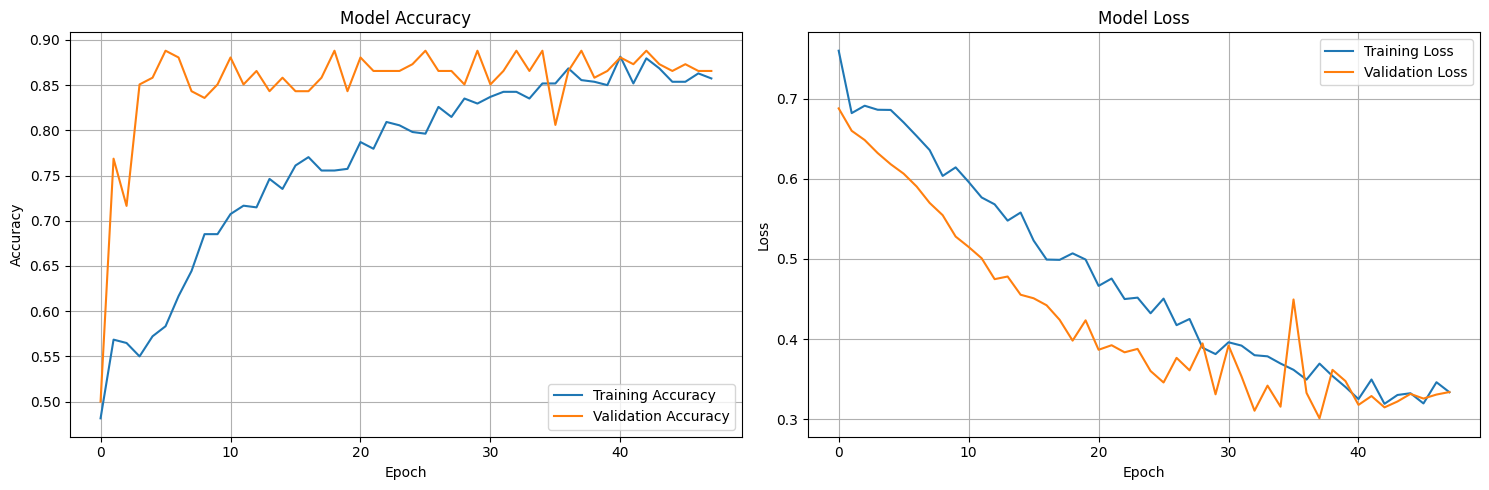

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 511ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.82      1.00      0.90        67
         vsd       1.00      0.78      0.87        67

    accuracy                           0.89       134
   macro avg       0.91      0.89      0.89       134
weighted avg       0.91      0.89      0.89       134



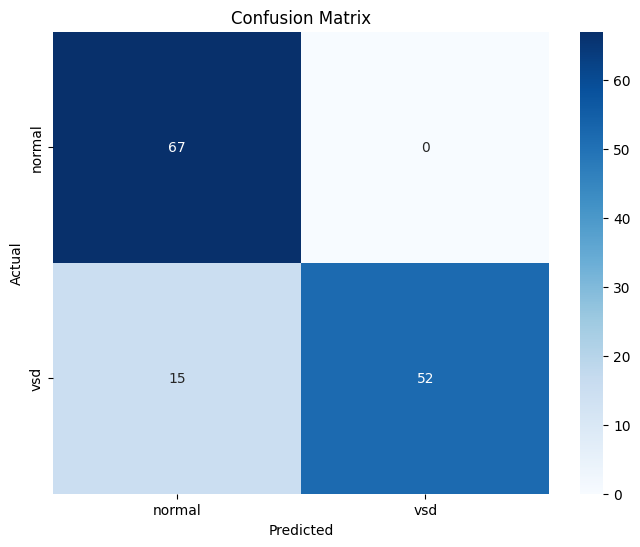

In [2]:
if __name__ == "__main__":
    main()

In [18]:
folder_path = os.getcwd()
ws_path = os.path.dirname(folder_path)

list_dir = os.listdir(ws_path)
prepro_data_path = ws_path + '/preproDataset'
nor_prepro_path = prepro_data_path + '/normal'
vsd_prepro_path = prepro_data_path + '/vsd'

In [3]:
from tensorflow.keras.models import load_model

model = load_model('best_vgg16_vsd_model.h5')
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    ws_path + '/preproDataset', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
# Evaluasi akurasi dan loss
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

NameError: name 'ws_path' is not defined

22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
              precision    recall  f1-score   support

      normal       0.71      0.85      0.78       337
         vsd       0.81      0.66      0.73       337

    accuracy                           0.75       674
   macro avg       0.76      0.75      0.75       674
weighted avg       0.76      0.75      0.75       674



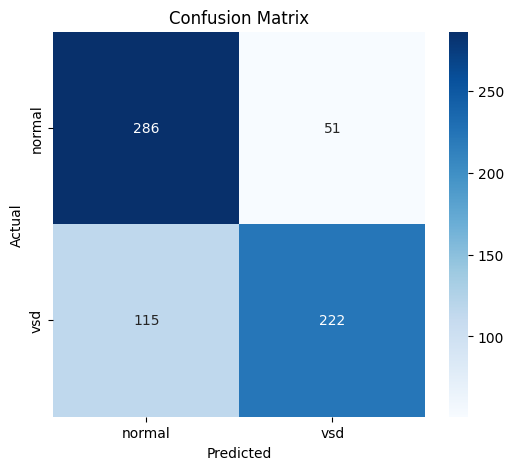

In [34]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
preds = model.predict(val_generator)
predicted_classes = (preds > 0.5).astype(int).flatten()

# Label asli
true_classes = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [17]:
import pandas as pd
import os

In [19]:
def dataPaths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    
    for fold in folds:
        foldPath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldPath)
        for file in filelist:
            fpath = os.path.join(foldPath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels


files, labels = dataPaths(prepro_data_path)

Fseries = pd.Series(files, name='path')
Lseries = pd.Series(labels, name='label')
df = pd.concat([Fseries, Lseries], axis=1)

mapping = {
    'normal': 0,
    'vsd': 1
}

df['encode'] = df['label'].map(mapping)
df.tail()

,path,label,encode
669,/home/kadafi/Documents/AWU/Heart-Leaks-Disease...,vsd,1
670,/home/kadafi/Documents/AWU/Heart-Leaks-Disease...,vsd,1
671,/home/kadafi/Documents/AWU/Heart-Leaks-Disease...,vsd,1
672,/home/kadafi/Documents/AWU/Heart-Leaks-Disease...,vsd,1
673,/home/kadafi/Documents/AWU/Heart-Leaks-Disease...,vsd,1


In [20]:
from sklearn.model_selection import train_test_split


y = df['label']

train_df, test_df = train_test_split(
    df, train_size=0.8, stratify=y, shuffle=True, random_state=None
)

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os


In [22]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(num_classes=2, fine_tune=False):
    """
    Build VGG16 model for VSD classification
    # 
    Args:
        num_classes: Number of classes (2 for normal/VSD)
        fine_tune: Whether to fine-tune VGG16 layers
    """
    # Load pre-trained VGG16 without top layers
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    # 
    # Freeze base model layers initially
    base_model.trainable = fine_tune
    # 
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    # 
    # Output layer
    if num_classes == 2:
        predictions = Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:
        predictions = Dense(num_classes, activation='softmax')(x)
        loss = 'categorical_crossentropy'
    # 
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    # 
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=loss,
        metrics=['accuracy']
    )
    # 
    return model

In [23]:
def train_model(train_generator, val_generator, epochs=2, model=None, 
                   patience=10, save_path='best_vgg16_baru_model.h5'):
    """
    Train the VGG16 model
    
    Args:
        train_generator: Training data generator
        val_generator: Validation data generator
        epochs: Number of training epochs
        patience: Early stopping patience
        save_path: Path to save the best model
    """
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            save_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    
    return history


In [26]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(
    rescale=1./255,
)

X = train_df['path']
y = train_df['label']

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
cv_scores = []

model = build_model()

for train_idx, valid_idx in kfold.split(X, y):
    x_train_df = train_df.iloc[train_idx]
    x_valid_df = train_df.iloc[valid_idx]

    train_generator = train_datagen.flow_from_dataframe(
        x_train_df,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',  # Use 'categorical' for multi-class
        shuffle=True
    )

    val_generator = val_datagen.flow_from_dataframe(
        x_valid_df,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',  # Use 'categorical' for multi-class
        shuffle=True
    )

    train_model(train_generator, val_generator, model=model)

Found 431 validated image filenames belonging to 2 classes.
Found 108 validated image filenames belonging to 2 classes.


/home/kadafi/Documents/AWU/Heart-Leaks-Disease-Classification/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2


2025-06-21 16:26:50.101338: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-06-21 16:26:50.218402: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2025-06-21 16:26:50.551267: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-06-21 16:26:50.621574: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-06-21 16:26:50.767183: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5389 - loss: 0.7428
Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to best_vgg16_baru_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5388 - loss: 0.7420 - val_accuracy: 0.5556 - val_loss: 0.6892 - learning_rate: 1.0000e-04
Epoch 2/2
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5617 - loss: 0.7267
Epoch 2: val_accuracy did not improve from 0.55556
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5581 - loss: 0.7287 - val_accuracy: 0.5185 - val_loss: 0.6837 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.
Found 431 validated image filenames belonging to 2 classes.
Found 108 validated image filenames belonging to 2 classes.


/home/kadafi/Documents/AWU/Heart-Leaks-Disease-Classification/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
 9/14 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4822 - loss: 0.7201

KeyboardInterrupt: 